In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
import cache_magic

from IPython.display import display, Image
import ipywidgets.widgets as widgets

from tracking_v2.target import ConstantVelocityTarget, NearConstantVelocityTarget, SingerTarget
from tracking_v2.kalman import LinearKalmanFilter
from tracking_v2.motion import ConstantVelocityModel, ConstantAccelerationModel, SingerAccelerationModel
from tracking_v2.sensor import GeometricSensor
from tracking_v2.evaluation import Runner, run_many, evaluate_many, plot_nees, evaluate_nees, \
                                   plot_error, evaluate_runner, plot_2d, plot_3d, nees_ci

from tracking.util import to_df

In [4]:
as_png        = True
image_counter = 0

def _show(fig):
    if not as_png:
        display(fig)
        return
    
    if not os.path.exists("images"):
        os.mkdir("images")
    
    global image_counter
    image_counter += 1
    path = "images/fig{count:02d}.png".format(count = image_counter)
    
    fig.write_image(path)
    display(Image(filename=path))

In [5]:
def _columns(*figs):
    width = int(100 / len(figs))
    
    outputs = []
    for fig in figs:
        output = widgets.Output(layout={'width': f'{width}%'})
        with output:
            _show(fig)
        outputs.append(output)
  
    column_layout = widgets.HBox(outputs)
    display(column_layout)

In [6]:
def _run_one(q, target):
    motion = ConstantVelocityModel(q)
    kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0]])

    sensor = GeometricSensor(seed=8)
    r = Runner(target, sensor, kf)
    r.run_many(1, 500)
    return r

In [7]:
def _plot_error_one(runner):
    tm  = np.arange(runner.n-100).reshape((runner.n-100, -1))
    err = np.hstack((tm, np.abs(runner.one_x_hat[100:,:3,0] - runner.truth[101:,:3])))
    err = to_df(err, columns=['time', 'x', 'y', 'z']).melt(['time'], ['x', 'y', 'z'], 'dim', 'error')
    return ex.line(err, x='time', y='error', facet_row='dim')

In [8]:
def _run_many(Q, target, m=100, seeds=None):
    motion = ConstantVelocityModel(Q)
    kf = LinearKalmanFilter(motion, [[1, 0, 0, 0, 0, 0],
                                     [0, 1, 0, 0, 0, 0],
                                     [0, 0, 1, 0, 0, 0]])
    sensor = GeometricSensor()
    r = Runner(target, sensor, kf)
    r.run_many(m, 500, seeds=seeds)
    return r

In [9]:
def _plot_nees(runner, skip=100):
    nees = evaluate_nees(runner.many_x_hat[:, :, :3, :], runner.many_P_hat[:, :, :3, :3], runner.many_truth[:, 1:, :3])
    err = np.asarray((np.arange(runner.n-skip), nees.scores[:,skip:].mean(axis=0))).T
    err = to_df(err, columns=['time', 'nees'])
    fig = ex.line(err, x='time', y='nees')
    
    ci = sp.stats.chi2.ppf([0.025, 0.975], runner.m * nees.dim) / runner.m
    fig.add_hline(y=ci[0], line_width=.5, line_dash="dash", line_color="red")
    fig.add_hline(y=ci[1], line_width=.5, line_dash="dash", line_color="red")

    return fig

In [10]:
def _plot_error_many(runner):
    tm  = np.arange(runner.n-100)
    err = np.linalg.norm(runner.many_x_hat[:,100:,:3,0] - runner.many_truth[:,101:,:3], axis=2)
    
    avg = np.array((tm, err.mean(axis=0))).T
    avg = to_df(avg, columns=['time', 'err'])
    avg['type'] = 'avg'
    
    low = np.array((tm, np.quantile(err, .025, axis=0))).T
    low = to_df(low, columns=['time', 'err'])
    low['type'] = '.025'
    
    upp = np.array((tm, np.quantile(err, .975, axis=0))).T
    upp = to_df(upp, columns=['time', 'err'])
    upp['type'] = '.975'

    err = pd.concat((avg, low, upp), axis=0).melt(['time', 'type'], ['err'], 'dim', 'error')
    return ex.line(err, x='time', y='error', color='type', facet_row='dim')

In [11]:
def _generate_metrics_1(target):
    data = []
    for Q in [0, .001, .002, .005, .01, .02, .05, .1, .2, .5, 1, 1.5, 2, 2.5, 5, 10, 20]:
        run  = _run_many(Q, target)
        nees = evaluate_nees(run.many_x_hat[:, 100:, :3, :], run.many_P_hat[:, 100:, :3, :3], run.many_truth[:,101:, :3])
        err  = np.linalg.norm(run.many_x_hat[:,100:,:3,0] - run.many_truth[:,101:,:3], axis=2)
        
        mean_nees = nees.scores.mean(axis=0)
        q975_nees = np.quantile(nees.scores, .975, axis=0)
    
        mean_err = err.mean(axis=0)
        q975_err = np.quantile(err, .975, axis=0)
    
        part = np.asarray((mean_nees, q975_nees, mean_err, q975_err)).T
        part = to_df(part, columns=['nees_mean', 'nees_q975', 'err_mean', 'err_q975'])
        part['Q'] = str(Q)
        
        data.append(part)
    return pd.concat(data)

In [12]:
def _generate_metrics_2(target):
    data = []
    for Q in [0, .001, .002, .005, .01, .02, .05, .1, .2, .5, 1, 1.5, 2, 2.5, 5, 10, 20]:
        run  = _run_many(Q, target)
        nees = evaluate_nees(run.many_x_hat[:, 100:, :3, :], run.many_P_hat[:, 100:, :3, :3], run.many_truth[:,101:, :3])
        err  = np.linalg.norm(run.many_x_hat[:,100:,:3,0] - run.many_truth[:,101:,:3], axis=2)
        
        part = np.asarray((nees.scores.reshape(-1), err.reshape(-1))).T
        part = to_df(part, columns=['nees', 'err'])
        part['Q'] = str(Q)
        
        data.append(part)
    return pd.concat(data)

# Target: Nearly Constant Velocity (non-zero noise intensity)

Target has noise intensity set to `1`.

When the motion model assumes process noise intensity as `0`, its filtered trajectory "roughly" follows the target, albeit with a growing absolute error. However, NEES grows without bounds because the filter's estimated covariance matrix converges to zero.

When the motion model matches the noise intensity (process Q = `1`), the absolute error remains low. NEES remains within the predicted confidence interval.

In [13]:
target = NearConstantVelocityTarget(noise_intensity=1)

In [14]:
ncv_q0_one = _run_one(0, target)
ncv_q1_one = _run_one(1, target)

In [15]:
_columns(plot_3d(ncv_q0_one), plot_3d(ncv_q1_one))

In [16]:
_columns(_plot_error_one(ncv_q0_one), _plot_error_one(ncv_q1_one))

In [17]:
_columns(_plot_nees(ncv_q0_one), _plot_nees(ncv_q1_one))

In [18]:
%cache ncv_target1_q0_many = _run_many(0, target, m=400, seeds=1)
%cache ncv_target1_q1_many = _run_many(1, target, m=400, seeds=1)

Loading cached value for variable 'ncv_target1_q0_many'. Time since caching: 0:31:07.106120
Loading cached value for variable 'ncv_target1_q1_many'. Time since caching: 0:30:16.988501


In [19]:
_columns(_plot_error_many(ncv_target1_q0_many), _plot_error_many(ncv_target1_q1_many))

In [20]:
_columns(_plot_nees(ncv_target1_q0_many), _plot_nees(ncv_target1_q1_many))

In [21]:
s = evaluate_runner(ncv_target1_q1_many)
l, u = nees_ci(ncv_target1_q1_many)

np.mean(np.logical_and(l <= s.position_nees.scores.mean(axis=0), s.position_nees.scores.mean(axis=0) <= u))

0.952

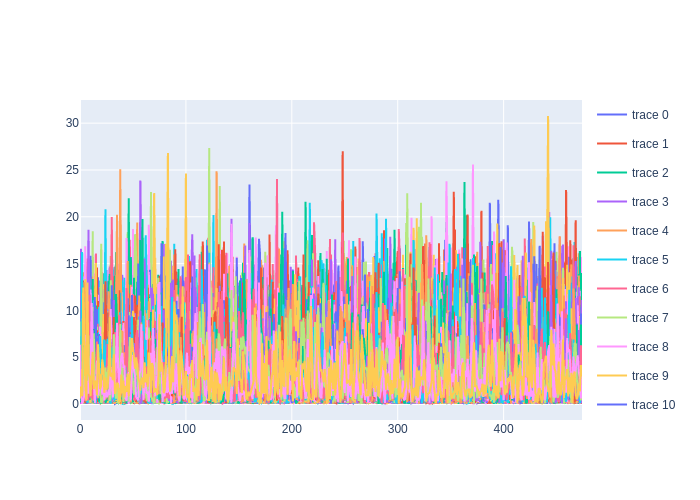

In [22]:
s = evaluate_runner(ncv_target1_q1_many)

fig = go.Figure()
for i in range(s.position_nees.scores.shape[0]):
    fig.add_trace(go.Scatter(x=np.arange(475), y=s.position_nees.scores[i,25:], mode='lines', legendgroup=i))
_show(fig)

## What about non-zero but mismatched Q?

In [23]:
target = NearConstantVelocityTarget(noise_intensity=2)

In [24]:
%cache ncv_target2_q1_many = _run_many(1, target, m=400, seeds=1)
%cache ncv_target2_q2_many = _run_many(2, target, m=400, seeds=1)
%cache ncv_target2_q3_many = _run_many(3, target, m=400, seeds=1)

Loading cached value for variable 'ncv_target2_q1_many'. Time since caching: 0:22:56.578564
Loading cached value for variable 'ncv_target2_q2_many'. Time since caching: 0:22:07.564512
Loading cached value for variable 'ncv_target2_q3_many'. Time since caching: 0:21:18.742229


In [25]:
_columns(_plot_error_many(ncv_target2_q1_many), _plot_error_many(ncv_target2_q2_many), _plot_error_many(ncv_target2_q3_many))

In [26]:
_columns(_plot_nees(ncv_target2_q1_many), _plot_nees(ncv_target2_q2_many), _plot_nees(ncv_target2_q3_many))